## Basic Animal Classification using 

In [ ]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchinfo import summary
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report

### Animal-10 Dataset

The Animals-10 Dataset contains approximately 28,000 medium-quality images categorized into 10 classes: dog, cat, horse, spider, butterfly, chicken, sheep, cow, squirrel, and elephant. These images were collected from Google Images and verified by humans, with some erroneous samples included to reflect real-world conditions, such as user-submitted images.

The dataset is organized into directories corresponding to each category, with class sizes ranging from 2,000 to 5,000 images. This dataset can simulate applications such as smart image galleries for researchers like biologists.

This dataset was downloaded from Kaggle and was submitted by Corrado Alessio.

### Preparing and Splitting Dataset 

First, we define a manual transformation pipeline, which resizes images to 224x224 pixels and converts them to tensors. The dataset is loaded using ImageFolder with the defined transformation applied. The dataset is then split into three subsets: training, testing, and validation. An 80-20 split is first applied to separate the training set from a combined test and validation set. This combined set is further divided into two equal parts for testing and validation. This setup ensures the dataset is properly preprocessed and divided for model evaluation.

In [2]:
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [3]:
base_dir = os.path.dirname('MCO')  
dataset_path = os.path.join(base_dir, 'archive', 'raw-img')

dataset = ImageFolder(root=dataset_path, transform=manual_transform)

In [4]:
# Create train dataset 
train_size = int(0.8 * len(dataset))
test_val_size = len(dataset) - train_size
train_data, test_val_data = random_split(dataset, [train_size, test_val_size])

# Create test and validation set from test_val_dataset
test_size = int(0.5 * len(test_val_data))
val_size = len(test_val_data) - test_size
test_data, val_data = random_split(test_val_data, [test_size, val_size])

# Check the len of the train, test, val dataset
len(train_data), len(test_data), len(val_data)

(20943, 2618, 2618)

### Setting Up Pre-trained EfficientNet-B0 with Data Transformations

This code sets up a pre-trained EfficientNet-B0 model using PyTorch's torchvision library. It loads default weights optimized on a large dataset (like ImageNet), prepares the model for the specified device (CPU or GPU), and retrieves the recommended data preprocessing steps (like resizing and normalization) that match the model's training. These transformations ensure the input data is properly formatted for accurate predictions.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


In [6]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [7]:
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### Creating Dataset with Pretrained Transformations

Earlier, we did manual_transform which provided the basic preprocessing we defined relating to image size. Now, we will also apply auto_transform which was predefined and tailored to the selected pre-trained model (EfficientNet). 

In this case, as shown above, the images are resized so that their shorter edge is 256 pixels while maintaining the aspect ratio. They are then cropped to a fixed size of 224x224 pixels to match the input dimensions expected by the model.  Bicubic interpolation is used during resizing, which provides smooth and high-quality image scaling. 

The images are also normalized using mean values [0.485, 0.456, 0.406] and standard deviations [0.229, 0.224, 0.225] for the red, green, and blue channels, respectively. This normalization ensures the pixel values are scaled and centered around zero with a standard deviation of one, consistent with the dataset (e.g., ImageNet) on which the model was originally trained. These steps collectively ensure compatibility with the model and optimize its performance.

The dataset is then split into three subsets: training, testing, and validation. An 80-20 split is first applied to separate the training set from a combined test and validation set. This combined set is further divided into two equal parts for testing and validation. This setup ensures the dataset is properly preprocessed and divided for model evaluation.

In [9]:
base_dir = os.path.dirname('MCO')  
dataset_path = os.path.join(base_dir, 'archive', 'raw-img')

dataset = ImageFolder(root=dataset_path, transform=auto_transforms)

In [ ]:
from torch.utils.data import Subset
import random

# Reduce the dataset size to 5%
reduced_indices = random.sample(range(len(dataset)), int(0.05 * len(dataset)))
reduced_dataset = Subset(dataset, reduced_indices)

# Perform splitting on reduced dataset
train_size = int(0.7 * len(reduced_dataset))
test_val_size = len(reduced_dataset) - train_size

train_dataset, test_val_dataset = random_split(reduced_dataset, [train_size, test_val_size])

test_size = int(0.4 * len(test_val_dataset))
val_size = len(test_val_dataset) - test_size

test_dataset, val_dataset = random_split(test_val_dataset, [test_size, val_size])

# Check the sizes
len(train_dataset), len(test_dataset), len(val_dataset)

(915, 157, 236)

### Creating DataLoaders
 In this stage, data loaders for training, testing, and validation datasets are created. This enables efficient data batching, shuffling, and parallel data loading during training or evaluation. 
 
 The lengths of the data loaders indicate the number of batches in each dataset, which are (655, 82, 82) for train_loader, test_loader, and val_loader respectively.

In [23]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=2)

val_loader = DataLoader(val_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False,
                       num_workers=2)

len(train_loader), len(test_loader), len(val_loader)

(58, 10, 15)

### Visualizing the Dataset



In [24]:
class_names = dataset.classes
class_names

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

In [25]:
translate = {
    "cane": "dog", 
    "cavallo": "horse", 
    "elefante": "elephant", 
    "farfalla": "butterfly", 
    "gallina": "chicken", 
    "gatto": "cat", 
    "mucca": "cow", 
    "pecora": "sheep", 
    "scoiattolo": "squirrel", 
    "ragno": "spider",
    "dog": "cane", 
    "elephant": "elefante", 
    "butterfly": "farfalla", 
    "chicken": "gallina", 
    "cat": "gatto", 
    "cow": "mucca", 
    "spider": "ragno", 
    "squirrel": "scoiattolo"
}

english_class_names = [translate[class_name] for class_name in class_names]
english_class_names

['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'spider',
 'squirrel']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.1461596].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the

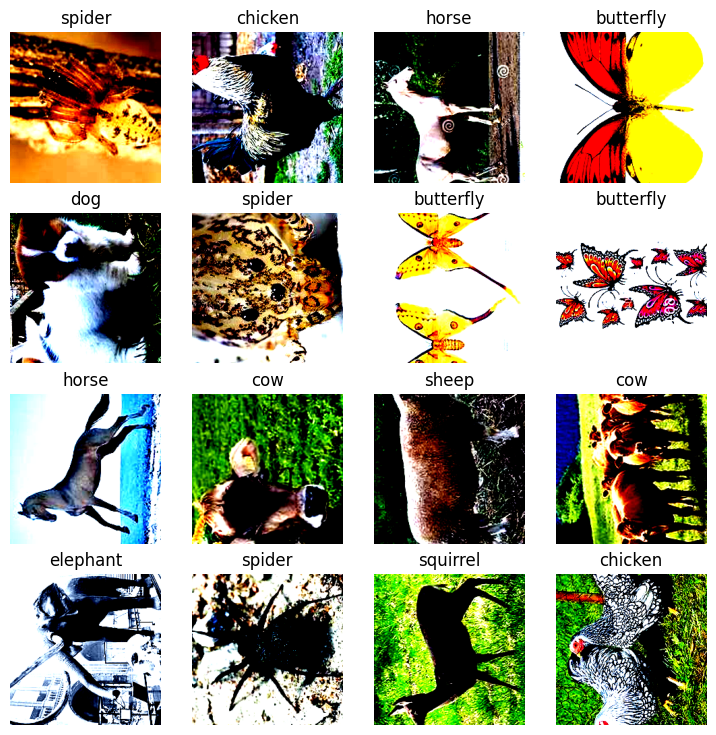

In [26]:
# Plot images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(2, 1, 0))
    plt.title(english_class_names[label])
    plt.axis(False); 

The code below freezes the base feature extractor. This prevents updates to these layers during training, ensuring only the newly added classifier layers are trained.

In [28]:
for param in model.features.parameters():
    param.requires_grad = False

The random number generators for both the CPU (torch.manual_seed) and GPU (torch.cuda.manual_seed) are seeded with the value 42 to ensure reproducibility of results by controlling the randomness in weight initialization and other stochastic processes.

The number of output units for the new classifier layer is determined based on the length of class_names, which corresponds to the number of target classes in the dataset.

The classifier section of the model is replaced with a new sequential layer. 

It includes:
- A Dropout layer with a dropout probability of 0.2 to help prevent overfitting.
- A Linear layer with 1280 input features and output_shape output units, where output_shape matches the number of classes. This layer is moved to the specified device (to(device)), such as a CPU or GPU.

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape,
                    bias=True)).to(device)

In [30]:
summary(model=model, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Defining Loss and Optimizer

The selected loss function is Cross-Entropy Loss since it is suitable for multi-class classification problems where each input belongs to exactly one of the classes. It measures the difference between the predicted class probabilities (output from the model) and the true class labels.

The selected optimizer is Adam optimizer, a widely used optimization algorithm combining the benefits of both momentum-based optimization and adaptive learning rates. The learning rate is set to 0.001 which controls how much the model's weights are adjusted in response to the computed gradient.

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

### Training and Testing the Model

Here, we set the random seed for reproducibility. A PyTorch model for 5 epochs using a training and validation dataset, Adam optimizer, and Cross Entropy Loss is trained. We also measure and print the total training time.

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer 
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_loader,
                       test_dataloader=val_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=1,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5110 | train_acc: 0.6193 | test_loss: 0.9928 | test_acc: 0.8514
[INFO] Total training time: 129.427 seconds


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer 
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_loader,
                       test_dataloader=val_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=3,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6525 | train_acc: 0.8987 | test_loss: 0.6751 | test_acc: 0.8806
Epoch: 2 | train_loss: 0.5035 | train_acc: 0.9138 | test_loss: 0.5282 | test_acc: 0.8944
Epoch: 3 | train_loss: 0.4332 | train_acc: 0.9102 | test_loss: 0.4697 | test_acc: 0.8944
[INFO] Total training time: 377.281 seconds


In [ ]:
def get_predictions_and_labels(model, dataloader, device):
    model.eval()  
    all_preds = []
    all_labels = []

    with torch.no_grad():  
        for batch in dataloader:
            inputs, labels = batch  
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) 
            

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return all_preds, all_labels

# Generate classification report
def generate_classification_report(model, dataloader, class_names, device):
    preds, labels = get_predictions_and_labels(model, dataloader, device)
    
    preds = preds.numpy()
    labels = labels.numpy()

    report = classification_report(labels, preds, target_names=class_names)
    print(report)

generate_classification_report(model, val_loader, english_class_names, device)


              precision    recall  f1-score   support

         dog       0.89      0.78      0.83        32
       horse       0.89      0.89      0.89        18
    elephant       0.91      0.87      0.89        23
   butterfly       0.92      0.92      0.92        24
     chicken       0.87      0.95      0.91        21
         cat       0.82      0.88      0.85        16
         cow       0.92      0.86      0.89        14
       sheep       0.75      0.86      0.80        21
      spider       0.98      0.96      0.97        49
    squirrel       0.89      0.94      0.92        18

    accuracy                           0.89       236
   macro avg       0.88      0.89      0.89       236
weighted avg       0.90      0.89      0.89       236

